Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from glob import glob
import random

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [9]:
### your code goes here, you can use training or validation data to visualize

# Custom Functions for plotting

# Function to generate image map
def generate_image_map(image_ds,batch_num=1):
  # Dictionary to store one image per label (0 to 9)
  label_image_map = {}
  # Iterate through the dataset without limiting the number of batches
  for images, labels in image_ds.skip(batch_num-1).take(1):
      # Loop through each image and its corresponding label
      for image, label in zip(images.numpy(), labels.numpy()):
          # If we haven't already stored an image for this label
          if label not in label_image_map:
              label_image_map[label] = image  # Store the image with the unique label
          # Stop once we have one image for each label (0 to 9)
          if len(label_image_map) == 10:
              break  # Exit the inner loop if all 10 labels are found
      if len(label_image_map) == 10:
          break  # Exit outer loop once all labels are covered
  # Sort the dictionary by keys
  sorted_image_map=dict(sorted(label_image_map.items()))
  # Display the keys of the dictionary to check which labels have been collected
  print("Labels found:", sorted_image_map.keys())
  return sorted_image_map


# Function to plot sample images
def plot_sample_images(class_names, label_image_map):
  plt.figure(figsize=(20, 10))
  for idx, (label, image) in enumerate(label_image_map.items()):
      plt.subplot(2, 5, idx + 1)  # Create a 2x5 grid for the images
      plt.imshow(image.astype("uint8"))  # Display the image
      plt.title(f"Class: {class_names[label]}")  # Display the class name
      plt.axis('off')  # Turn off the axis
  # Show the plot with all images
  plt.tight_layout()
  plt.show()

In [10]:
# Genarate random batch number between 0 and 10
batch_num=random.randint(1,11)
batch_num

4

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


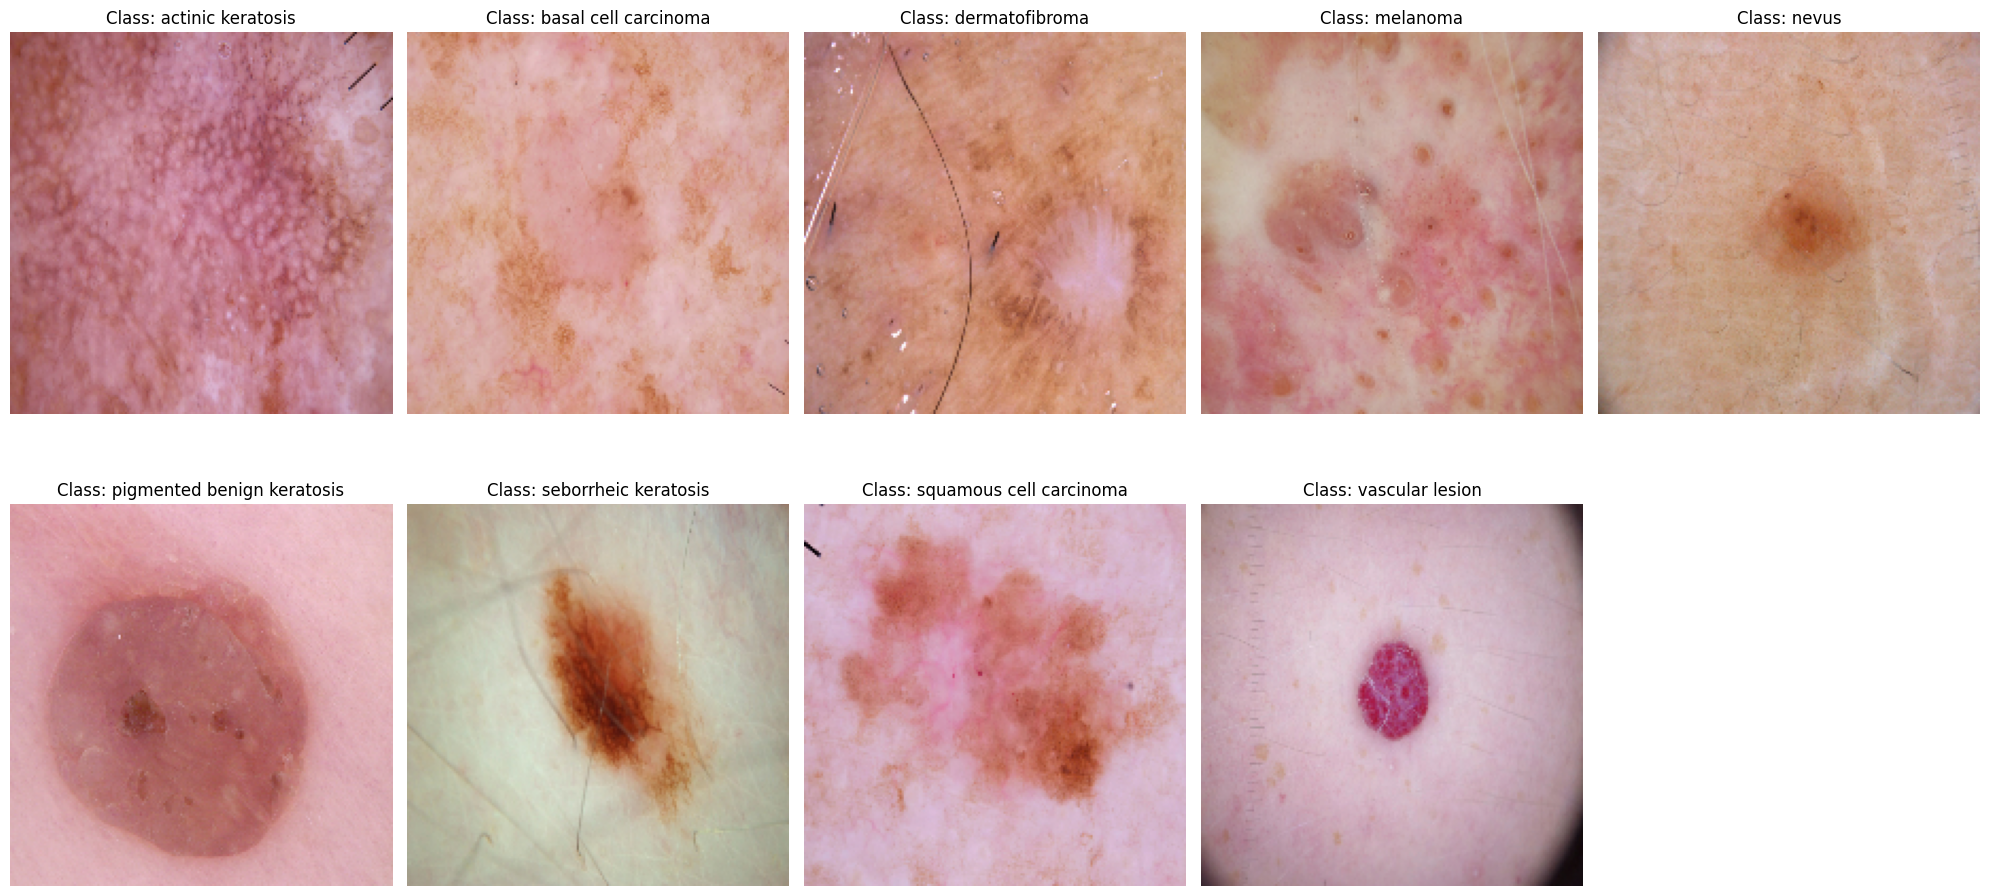

In [11]:
# Visualize Train Data
train_image_map=generate_image_map(train_ds,batch_num)
plot_sample_images(class_names,train_image_map)

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


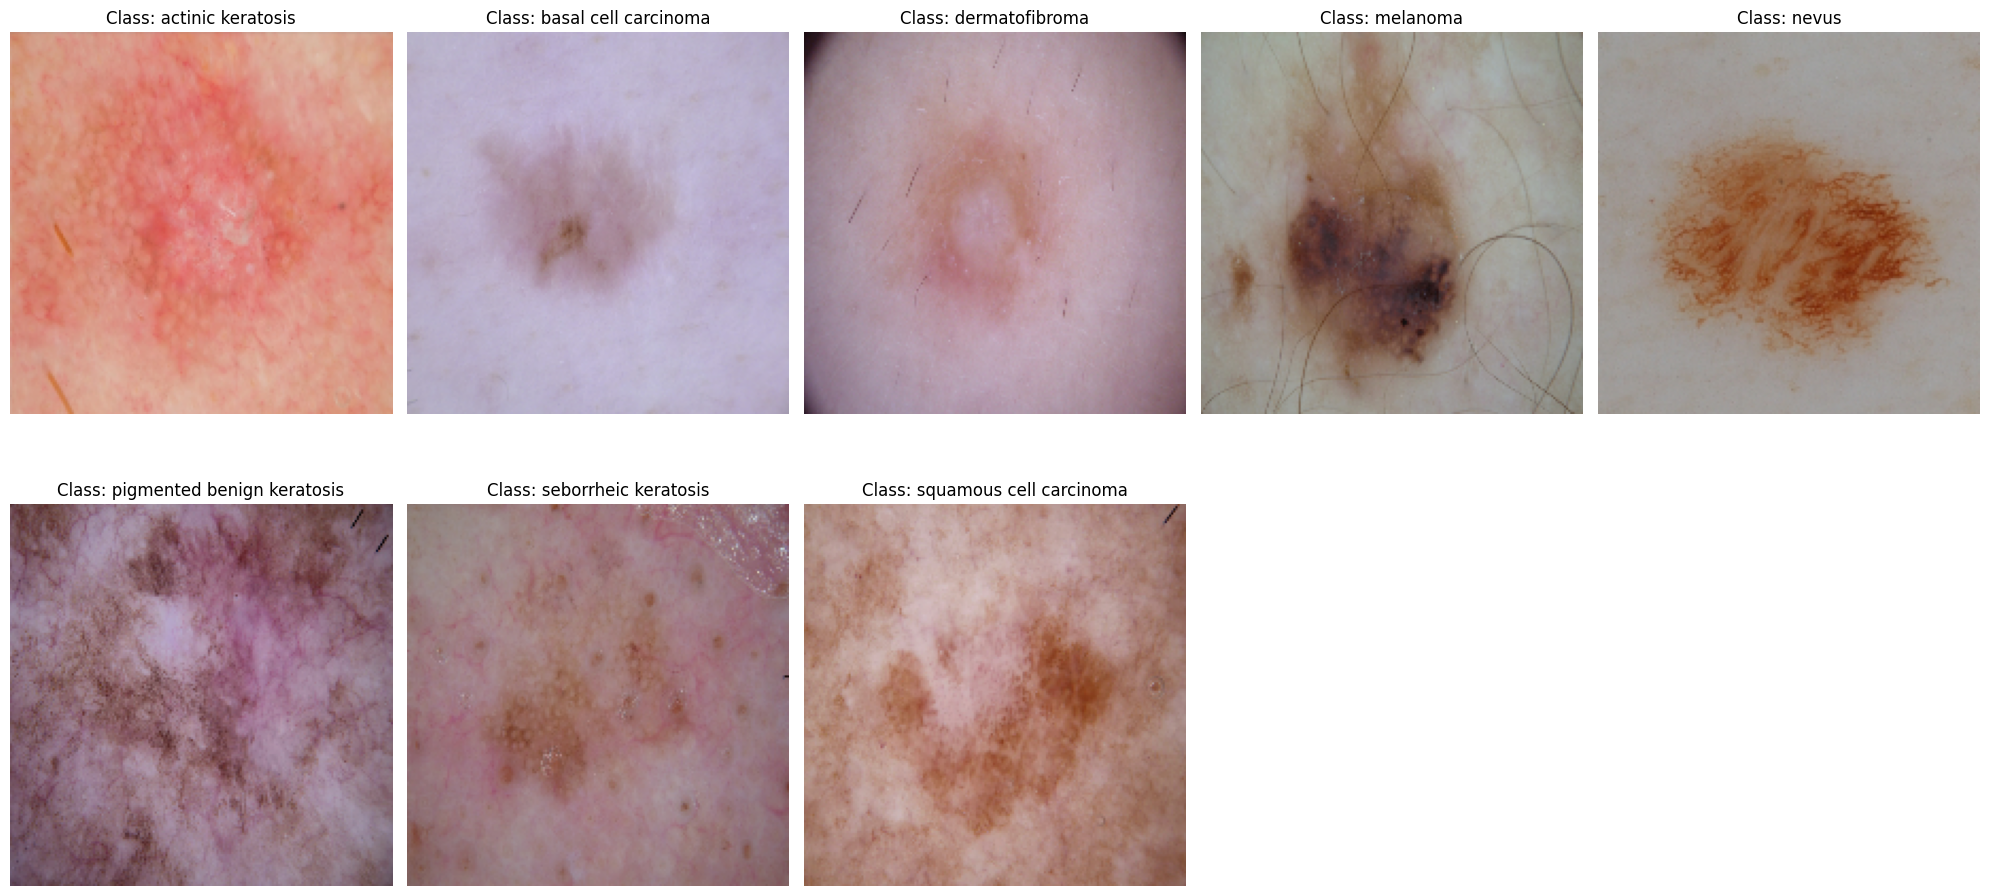

In [12]:
# Visualize Validation Data
val_image_map=generate_image_map(val_ds,batch_num)
plot_sample_images(class_names,val_image_map)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# First Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
# Second Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_1")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 182s 555ms/step - accuracy: 0.1941 - loss: 3.7690 - val_accuracy: 0.3602 - val_loss: 1.7815
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3448 - loss: 1.7847 - val_accuracy: 0.4743 - val_loss: 1.5065
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4340 - loss: 1.5751 - val_accuracy: 0.5123 - val_loss: 1.5174
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4806 - loss: 1.4928 - val_accuracy: 0.5369 - val_loss: 1.3801
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5146 - loss: 1.3940 - val_accuracy: 0.5257 - val_loss: 1.4530
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5259 - loss: 1.3446 - val_accuracy: 0.5302 - val_loss: 1.4227
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5672 - loss: 1.2341 - val_accuracy: 0.5727 - val_loss: 1.3294
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5674 - loss: 1.2265 - val_accuracy: 0.4966 

### Visualizing training results

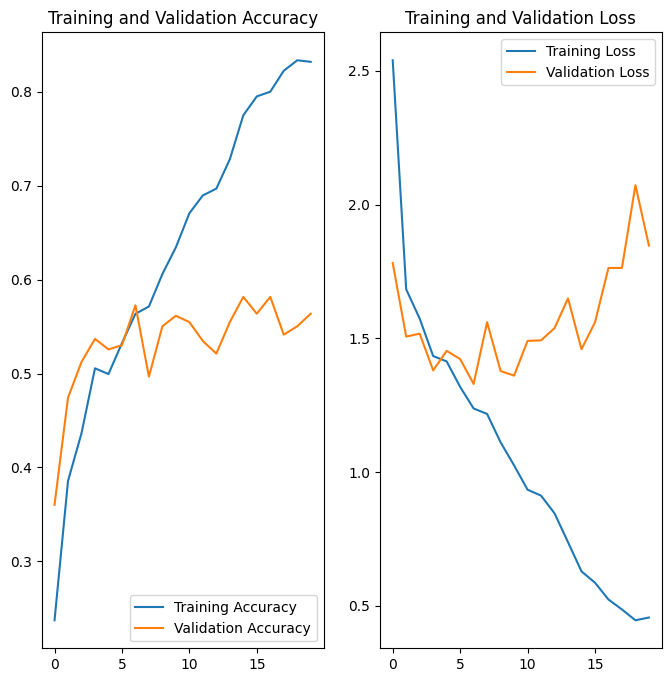

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
- The training accuracy steadily improve to 88% by the 20th epoch, indicating that - the model is learning and fitting the training data well.
- The validation accuracy, on the other hand, peaks at around 55% and - then stagnates or decreases by the 20th epoch. This shows that the model - is not generalizing well to unseen data and starts to overfit after a - certain point.
- While the training loss continues to drop, the validation loss increases significantly over time by the 20th epoch.

<b><i>The model is overfitting, as indicated by the widening gap between the training and validation performance</i></b>

### Data augmentation

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=123 ),
  layers.RandomRotation(0.2, seed=123),
  layers.RandomZoom(0.2, seed=123),
] , name="Data_Augmentation_Layer")

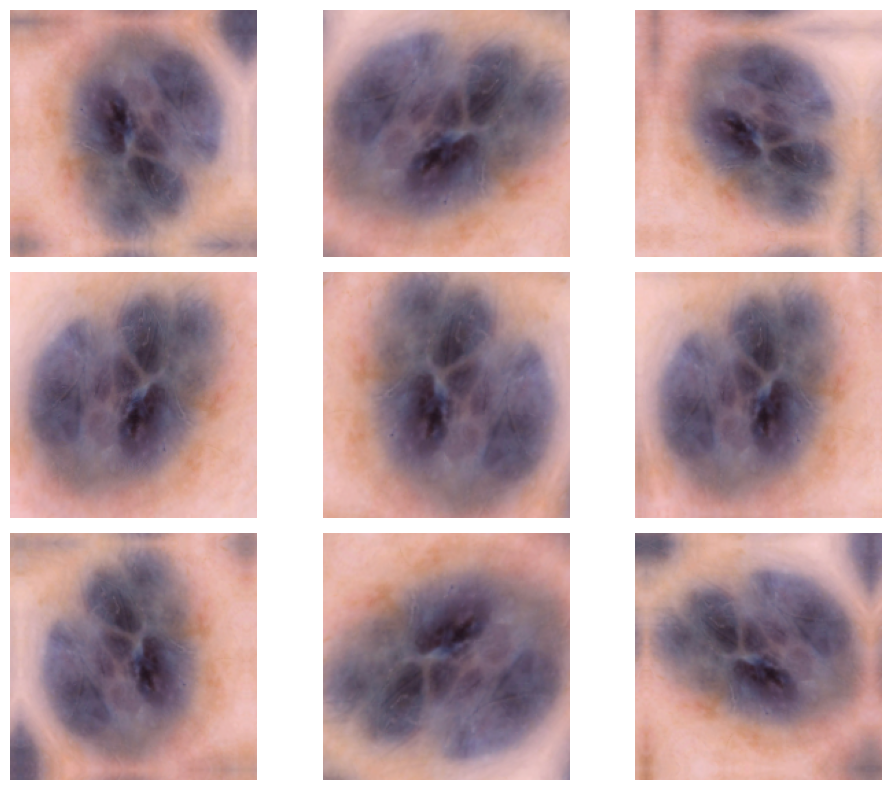

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
random_num=random.randint(1,11)
# Your code goes here
plt.figure(figsize=(10, 8))
for images, _ in train_ds.skip(random_num-1).take(random_num):
  for i in range(9):
    augmented_images = data_augmentation(images) # data augmenatation
    ax = plt.subplot(3, 3, i + 1) # Create a 3x3 grid for the images
    plt.imshow(augmented_images[random_num].numpy().astype("uint8")) # Display the image
    plt.axis("off") # Turn off the axis
# Show the plot with all images
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
model.add( data_augmentation )
# First Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
# Second Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_3")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.1702 - loss: 7.1901 - val_accuracy: 0.1924 - val_loss: 2.0866
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2008 - loss: 2.0598 - val_accuracy: 0.2528 - val_loss: 2.0535
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2640 - loss: 1.9768 - val_accuracy: 0.3020 - val_loss: 1.9906
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2621 - loss: 1.9620 - val_accuracy: 0.3378 - val_loss: 1.9361
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3034 - loss: 1.8981 - val_accuracy: 0.4430 - val_loss: 1.6498
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3794 - loss: 1.7041 - val_accuracy: 0.3177 - val_loss: 1.8542
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3816 - loss: 1.7307 - val_accuracy: 0.3490 - val_loss: 1.7624
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4483 - loss: 1.5799 - val_accuracy: 0.4273 - v

### Visualizing the results

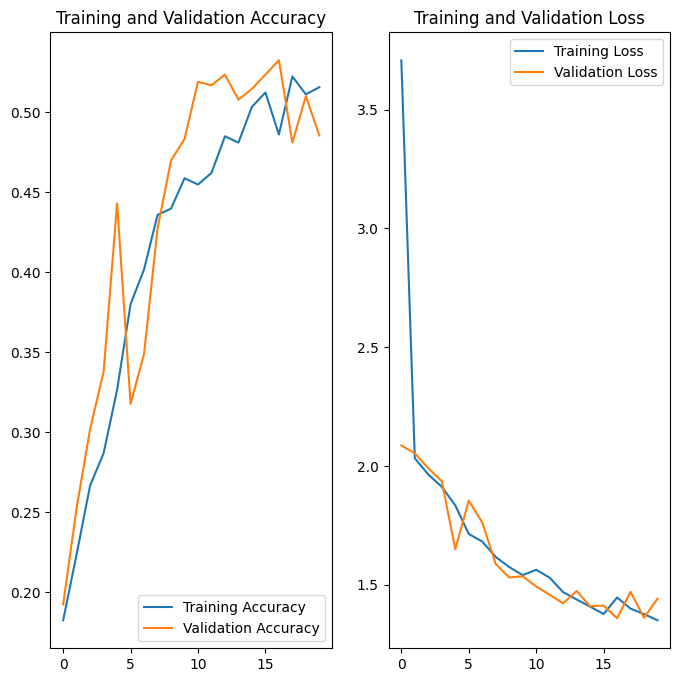

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Findings:
- The training accuracy and validation accuracy are almost the same but are both quite low, indicating that the model is likely underfitting.
- The training loss is very low, while the validation loss fluctuates significantly.
- These results suggest that the current model is not performing well and requires improvement.
- Additionally, addressing the issue of class imbalance could further - improve the model's performance.

### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
list_images = []
for i in class_names:
    list_images.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

data = {'Class Names': class_names, 'Image Count': list_images}
original_df = pd.DataFrame(data)

In [28]:
original_df.head(9)

Class Names  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Answer - seborrheic keratosis has the least number of samples - 77
#### - Which classes dominate the data in terms proportionate number of samples?
Answer - pigmented benign keratosis dominates the data in terms proportionate number of samples - 462


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    class_path = path_to_training_dataset + i + '/output'
    # Check if 'output' folder exists and has the required number of images
    if os.path.exists(class_path) and len(os.listdir(class_path)) >= target_sample_size:
        print(f"Augmentation already done for class '{i}', skipping augmentation.")
    else:
        print(f"Augmenting class '{i}' as required samples are not present.")
    # Create an Augmentor pipeline for the class if augmentation is needed
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmenting class 'actinic keratosis' as required samples are not present.
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47F05A8AC0>: 100%|██████████| 500/500 [00:06<00:00, 80.14 Samples/s]


Augmenting class 'basal cell carcinoma' as required samples are not present.
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47F0625870>: 100%|██████████| 500/500 [00:06<00:00, 79.95 Samples/s]


Augmenting class 'dermatofibroma' as required samples are not present.
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A47B4173A30>: 100%|██████████| 500/500 [00:05<00:00, 89.09 Samples/s]


Augmenting class 'melanoma' as required samples are not present.
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A47B05F7100>: 100%|██████████| 500/500 [00:18<00:00, 26.32 Samples/s]


Augmenting class 'nevus' as required samples are not present.
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A47F9489390>: 100%|██████████| 500/500 [00:16<00:00, 29.86 Samples/s]


Augmenting class 'pigmented benign keratosis' as required samples are not present.
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A47B0402710>: 100%|██████████| 500/500 [00:05<00:00, 89.58 Samples/s]


Augmenting class 'seborrheic keratosis' as required samples are not present.
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A47F052EB30>: 100%|██████████| 500/500 [00:09<00:00, 51.61 Samples/s]


Augmenting class 'squamous cell carcinoma' as required samples are not present.
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A47B4171600>: 100%|██████████| 500/500 [00:05<00:00, 86.65 Samples/s]


Augmenting class 'vascular lesion' as required samples are not present.
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A47B040ACB0>: 100%|██████████| 500/500 [00:05<00:00, 88.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000067.jpg_654322f0-08de-45fb-84f0-6dd69ea0a011.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000479.jpg_f8d9bac5-8cf2-42eb-8821-4d5b6db21e3c.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000329.jpg_88438b72-bb6c-40cd-88d4-1f17e36e2a32.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000238.jpg_431aa326-da7d-4b86-8f81-158eae133b09.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],ignore_index=True)

In [36]:
new_df['Label'].value_counts()

Label
nevus                         500
squamous cell carcinoma       500
basal cell carcinoma          500
seborrheic keratosis          500
pigmented benign keratosis    500
melanoma                      500
dermatofibroma                500
actinic keratosis             500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
data_dir_train="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Todo:** Create your model (make sure to include normalization)

#### Create your model

In [40]:
## your code goes here
model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model.add(data_augmentation)

# First Part
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_1"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
model.add(layers.Dropout(0.20, name="Dropout_1"))  # adding dropout

# Second Part
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_2"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
model.add(layers.Dropout(0.20, name="Dropout_2"))  # adding dropout

# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model.add(layers.Dense(units=128, name="FC_Layer_1"))
model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_3"))
model.add(layers.Dropout(0.20, name="Dropout_3"))  # adding dropout

# Output Layer
model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,610,377 (63.36 MB)

 Trainable params: 16,609,929 (63.36 MB)

 Non-trainable params: 448 (1.75 KB)

#### **Todo:**  Train your model

In [43]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.3299 - loss: 1.8319 - val_accuracy: 0.1151 - val_loss: 2.6862
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4631 - loss: 1.4234 - val_accuracy: 0.1455 - val_loss: 2.5451
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.4841 - loss: 1.3386 - val_accuracy: 0.3044 - val_loss: 1.8703
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5138 - loss: 1.2635 - val_accuracy: 0.5071 - val_loss: 1.2949
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5318 - loss: 1.2332 - val_accuracy: 0.3853 - val_loss: 1.7741
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5588 - loss: 1.1885 - val_accuracy: 0.4521 - val_loss: 1.4223
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5627 - loss: 1.1458 - val_accuracy: 0.4573 - val_loss: 1.4773
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.5791 - loss: 1

#### **Todo:**  Visualize the model results

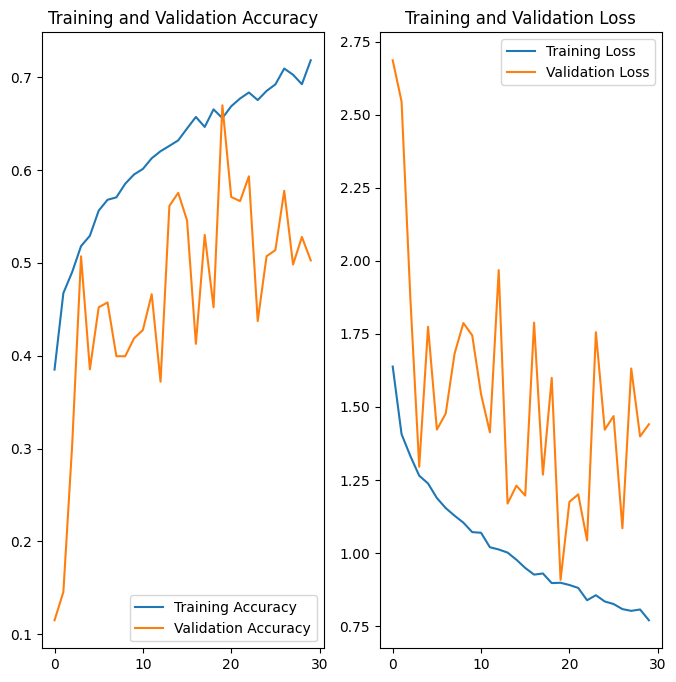

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Include Callbacks and adjust Dropouts ( gradually increase dropout percentages )

In [52]:
## your code goes here
model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model.add(data_augmentation)

# First Part
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_1"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
model.add(layers.Dropout(0.25, name="Dropout_1"))  # adding dropout

# Second Part
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_2"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model.add(layers.Dense(units=128, name="FC_Layer_1"))
model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_3"))
model.add(layers.Dropout(0.40, name="Dropout_3"))  # adding dropout

# Output Layer
model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.2,
                                  min_lr=1e-7)

# View the summary of all layers
model.summary()


Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [53]:
epochs = 30
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.2975 - loss: 2.0857 - val_accuracy: 0.1143 - val_loss: 2.7756 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4230 - loss: 1.5450 - val_accuracy: 0.1180 - val_loss: 2.4837 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.4604 - loss: 1.4243 - val_accuracy: 0.3022 - val_loss: 1.9641 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.4745 - loss: 1.3710 - val_accuracy: 0.2509 - val_loss: 1.9927 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5025 - loss: 1.2825 - val_accuracy: 0.3994 - val_loss: 1.5451 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5285 - loss: 1.2553 - val_accuracy: 0.4625 - val_loss: 1.4154 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.5214 

Visualize the model results

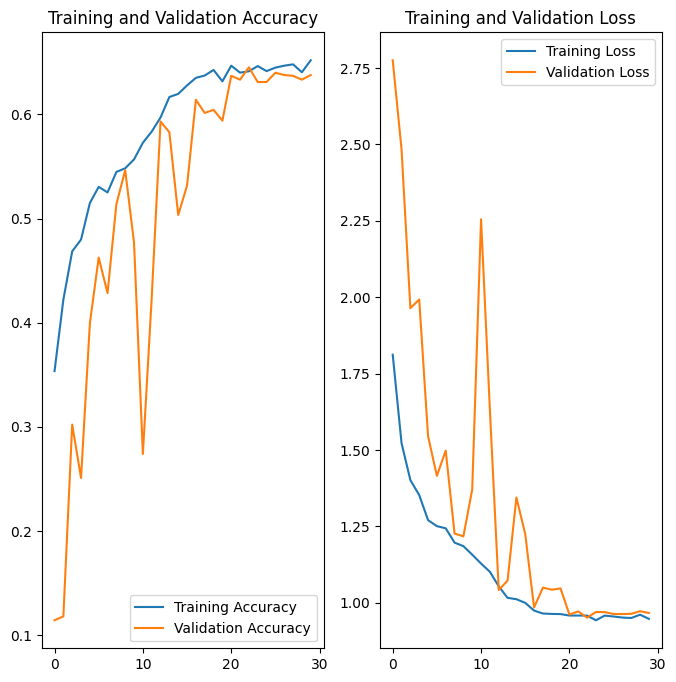

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Let's try with little increased Learning rate and also include Callbacks

Create the Model

In [60]:
## your code goes here
model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model.add(data_augmentation)

# First Part
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_1"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
model.add(layers.Dropout(0.25, name="Dropout_1"))  # adding dropout

# Second Part
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_2"))  # adding second Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_2"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model.add(layers.Dense(units=128, name="FC_Layer_1"))
model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_3"))
model.add(layers.Dropout(0.40, name="Dropout_3"))  # adding dropout

# Output Layer
model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # Reduce learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1, # reduce factor
                                  min_lr=1e-7)

# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [61]:
epochs = 30
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 99ms/step - accuracy: 0.3196 - loss: 1.9502 - val_accuracy: 0.1336 - val_loss: 2.3702 - learning_rate: 0.0100
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.4241 - loss: 1.5102 - val_accuracy: 0.2992 - val_loss: 1.7459 - learning_rate: 0.0100
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.4544 - loss: 1.4338 - val_accuracy: 0.4417 - val_loss: 1.4674 - learning_rate: 0.0100
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.4658 - loss: 1.3872 - val_accuracy: 0.4031 - val_loss: 1.6401 - learning_rate: 0.0100
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.4636 - loss: 1.3943 - val_accuracy: 0.4009 - val_loss: 1.5407 - learning_rate: 0.0100
Epoch 6/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4929 - loss: 1.3141
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.4929 - los

Visualize the model results

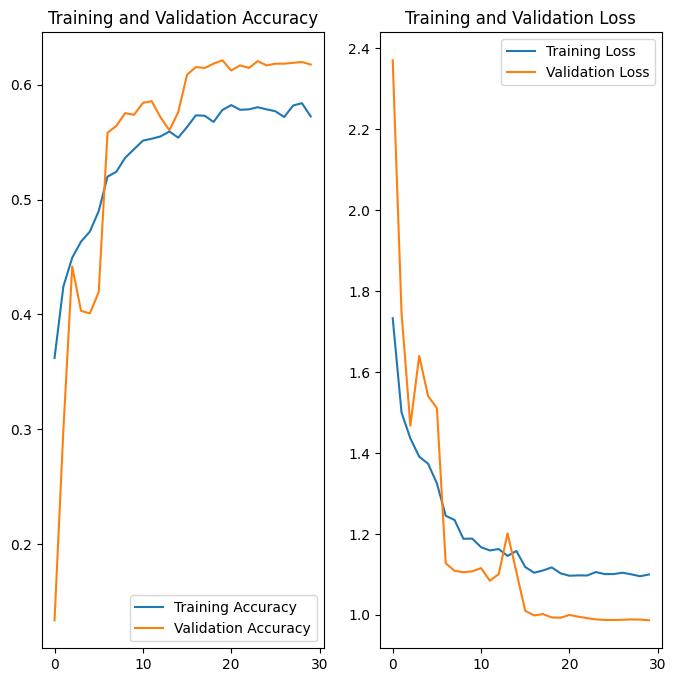

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Default Learning Rate and increased Epoch Value

In [ ]:
## your code goes here
model = Sequential(name="Melanoma_Detection_Model")

# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model.add(data_augmentation)

# First Part
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_1"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer
model.add(layers.Dropout(0.25, name="Dropout_1"))  # adding dropout

# Second Part
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", name="Conv2D_Layer_2"))  # adding second Convolution layer
model.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_2"))
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer
model.add(layers.Dropout(0.30, name="Dropout_2"))  # adding dropout

# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model.add(layers.Dense(units=128, name="FC_Layer_1"))
model.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model.add(layers.Activation('relu', name="ReLU_Activation_3"))
model.add(layers.Dropout(0.40, name="Dropout_3"))  # adding dropout

# Output Layer
model.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.2,
                                  min_lr=1e-9)

# View the summary of all layers
model.summary()


Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 180, 180, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,610,377 (63.36 MB)

 Trainable params: 16,609,929 (63.36 MB)

 Non-trainable params: 448 (1.75 KB)

Train the model

In [ ]:
epochs = 50
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.3081 - loss: 1.9917 - val_accuracy: 0.1151 - val_loss: 2.8992 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4258 - loss: 1.4906 - val_accuracy: 0.1626 - val_loss: 2.6501 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.4581 - loss: 1.4164 - val_accuracy: 0.3370 - val_loss: 1.8622 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.4795 - loss: 1.3537 - val_accuracy: 0.3927 - val_loss: 1.6565 - learning_rate: 0.0010
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.4993 - loss: 1.2867 - val_accuracy: 0.2747 - val_loss: 2.5784 - learning_rate: 0.0010
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5221 - loss: 1.2453 - val_accuracy: 0.4261 - val_loss: 1.6044 - learning_rate: 0.0010
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.5

Visualize the model results

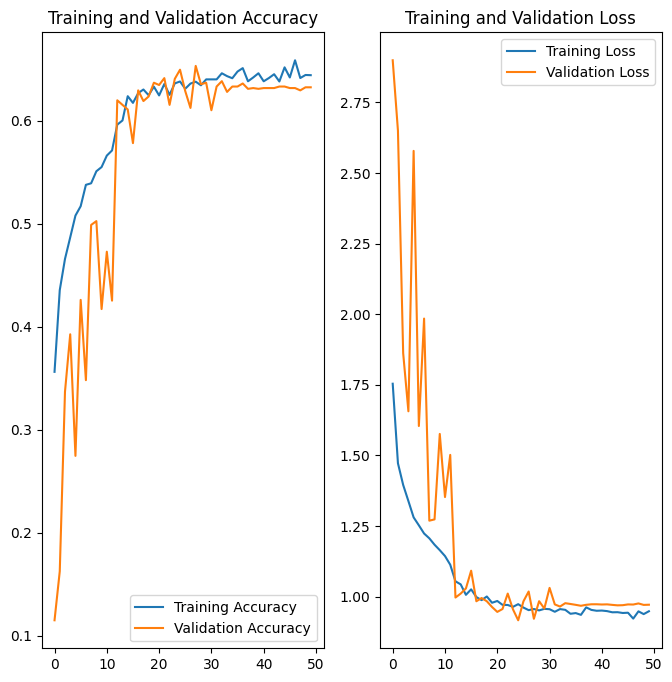

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Create more layers and adjust dropuouts

Create the Model

In [64]:
# Create the Model
model_morelayers = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
model_morelayers.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model_morelayers.add(data_augmentation)

# First Part
model_morelayers.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_32F"))  # adding first Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_1"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
model_morelayers.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_64F"))  # adding second Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_2"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
model_morelayers.add(layers.Conv2D(filters=128,kernel_size=(3,3), name="Conv2D_Layer_128F")) # adding third Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_3"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding third Max Pooling layer
model_morelayers.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts

# Fouth Part
model_morelayers.add(layers.Conv2D(filters=256,kernel_size=(3,3), name="Conv2D_Layer_256F")) # adding third Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_4"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_4")) # adding third Max Pooling layer
model_morelayers.add(layers.Dropout(0.50 ,name="Dropout_2") )# adding dropouts

# Flattening the output
model_morelayers.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=256, name="FC_Layer_256N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_5"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_5"))
model_morelayers.add(layers.Dropout(0.30, name="Dropout_3"))  # adding dropout

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=128, name="FC_Layer_128N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_6"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_6"))
model_morelayers.add(layers.Dropout(0.50, name="Dropout_4"))  # adding dropout

# Output Layer
model_morelayers.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
model_morelayers.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
model_morelayers.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F (Conv2D)            │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F (Conv2D)            │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_128F (Conv2D)           │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_256F (Conv2D)           │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_4 (MaxPooling2D)  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,734,601 (21.88 MB)

 Trainable params: 5,732,873 (21.87 MB)

 Non-trainable params: 1,728 (6.75 KB)

Train the model

In [65]:
epochs = 30
history_morelayers = model_morelayers.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.2739 - loss: 2.1525 - val_accuracy: 0.1151 - val_loss: 2.6931 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.3954 - loss: 1.6245 - val_accuracy: 0.1915 - val_loss: 2.4711 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4242 - loss: 1.5142 - val_accuracy: 0.3779 - val_loss: 1.5403 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - accuracy: 0.4525 - loss: 1.4235 - val_accuracy: 0.3860 - val_loss: 1.5456 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.4705 - loss: 1.3708 - val_accuracy: 0.4581 - val_loss: 1.3671 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.4880 - loss: 1.3064 - val_accuracy: 0.3482 - val_loss: 1.9058 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.5

Visualize the model results

In [66]:
acc = history_morelayers.history['accuracy']
val_acc = history_morelayers.history['val_accuracy']

loss = history_morelayers.history['loss']
val_loss = history_morelayers.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Remove dropuout layers and check

Create the Model

In [68]:
# Create the Model
model_morelayers = Sequential(name="Melanoma_Detection_Model_More_Layers")

# Adding Rescaling layer
model_morelayers.add(layers.Rescaling(1.0/255.0, offset=0.0, input_shape=(img_height, img_width, 3), name="Rescaling_Layer"))

# Adding Data Augmentation
model_morelayers.add(data_augmentation)

# First Part
model_morelayers.add(layers.Conv2D(filters=32, kernel_size=(3,3), name="Conv2D_Layer_32F"))  # adding first Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_1"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_1"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1"))  # adding first Max Pooling layer

# Second Part
model_morelayers.add(layers.Conv2D(filters=64, kernel_size=(3,3), name="Conv2D_Layer_64F"))  # adding second Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_2"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_2"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2"))  # adding second Max Pooling layer

# Third Part
model_morelayers.add(layers.Conv2D(filters=128,kernel_size=(3,3), name="Conv2D_Layer_128F")) # adding third Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_3"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_3"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_3")) # adding third Max Pooling layer

# Fouth Part
model_morelayers.add(layers.Conv2D(filters=256,kernel_size=(3,3), name="Conv2D_Layer_256F")) # adding third Convolution layer
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_4"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_4"))
model_morelayers.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_4")) # adding third Max Pooling layer
model_morelayers.add(layers.Dropout(0.50 ,name="Dropout_1") )# adding dropouts

# Flattening the output
model_morelayers.add(layers.Flatten(name="Flatten_Layer"))

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=256, name="FC_Layer_256N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_5"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_5"))
model_morelayers.add(layers.Dropout(0.25, name="Dropout_3"))  # adding dropout

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=128, name="FC_Layer_128N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_6"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_6"))
model_morelayers.add(layers.Dropout(0.25, name="Dropout_4"))  # adding dropout

# Fully Connected Layer
model_morelayers.add(layers.Dense(units=64, name="FC_Layer_64N"))
model_morelayers.add(layers.BatchNormalization(name="BatchNorm_Layer_7"))  # adding normalization
model_morelayers.add(layers.Activation('relu', name="ReLU_Activation_7"))
model_morelayers.add(layers.Dropout(0.25, name="Dropout_5"))  # adding dropout

# Output Layer
model_morelayers.add(layers.Dense(units=len(class_names), activation="softmax", name="Output_Layer"))  # adding output layer

# Compile the model
model_morelayers.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set callbacks
learn_control = ReduceLROnPlateau(monitor='val_accuracy',
                                  patience=3,
                                  verbose=1,
                                  factor=0.1,
                                  min_lr=1e-7)

# View the summary of all layers
model_morelayers.summary()

Model: "Melanoma_Detection_Model_More_Layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_32F (Conv2D)            │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_1                    │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_1 (Activation)       │ (None, 178, 178, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_64F (Conv2D)            │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_2                    │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_2 (Activation)       │ (None, 87, 87, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_128F (Conv2D)           │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_3                    │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_3 (Activation)       │ (None, 41, 41, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_3 (MaxPooling2D)  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_256F (Conv2D)           │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Layer_4                    │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Activation_4 (Activation)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_4 (MaxPooling2D)  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,742,537 (21.91 MB)

 Trainable params: 5,740,681 (21.90 MB)

 Non-trainable params: 1,856 (7.25 KB)

Train the model

In [69]:
epochs = 30
history_morelayers = model_morelayers.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[learn_control],
                    verbose=1)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.2755 - loss: 2.0066 - val_accuracy: 0.1151 - val_loss: 2.3387 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.4107 - loss: 1.5350 - val_accuracy: 0.1834 - val_loss: 2.1716 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.4322 - loss: 1.4828 - val_accuracy: 0.3898 - val_loss: 1.6049 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.4758 - loss: 1.3872 - val_accuracy: 0.5212 - val_loss: 1.2534 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.4860 - loss: 1.3495 - val_accuracy: 0.5085 - val_loss: 1.2689 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.5110 - loss: 1.2840 - val_accuracy: 0.3675 - val_loss: 1.8442 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.517

Visualize the model results

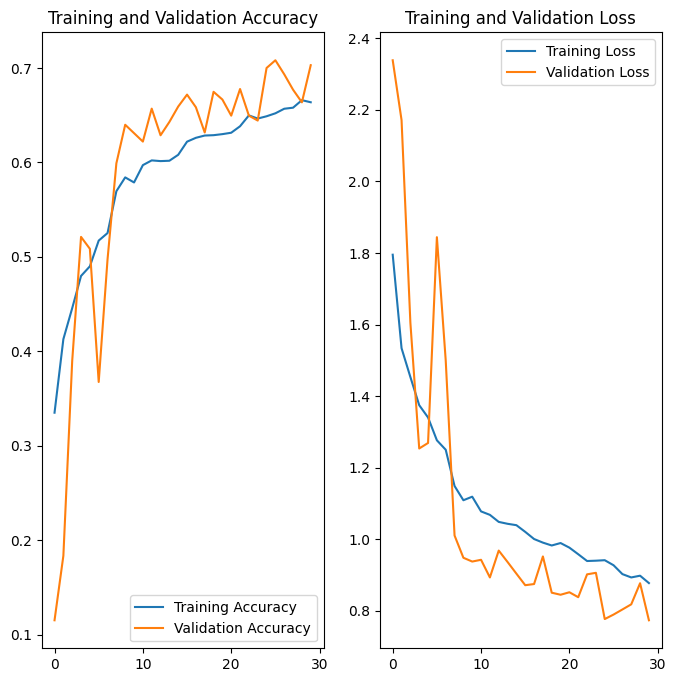

In [70]:
acc = history_morelayers.history['accuracy']
val_acc = history_morelayers.history['val_accuracy']

loss = history_morelayers.history['loss']
val_loss = history_morelayers.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluation on Test Set

Test dataset creation

In [71]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,  # Path to the test data directory
    labels='inferred',  # Automatically infer labels from subdirectories
    label_mode='int',  # Labels will be integers
    class_names=None,  # Infer class names automatically
    color_mode='rgb',  # Images are in RGB
    batch_size=32,  # Batch size
    image_size=(img_height, img_width),  # Image size to resize to
    shuffle=False,  # Do not shuffle test data
    interpolation='bilinear',  # Interpolation method
    follow_links=False  # Follow symbolic links
)


Found 118 files belonging to 9 classes.


Prediction on Train Test Validation Set

In [78]:
def evaluate_accuracy(model_inp, data_inp):
    loss, accuracy = model_inp.evaluate(data_inp)  # Use the passed model for evaluation
    return accuracy

model_dict = {
    "Base Model": [model, history],
    "Base Model + More Layers": [model_morelayers, history_morelayers]
}

# Report dataframe
report_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

# Run through the list of models to generate the report
for key, items in model_dict.items():
    df = pd.DataFrame([{
        'Model': key,  # Model name
        'Train Accuracy': round(items[1].history['accuracy'][-1], 2),  # Get the accuracy of training data at the last epoch
        'Validation Accuracy': round(items[1].history['val_accuracy'][-1], 2),  # Get the accuracy of validation data at the last epoch
        'Test Accuracy': round(evaluate_accuracy(items[0], test_ds), 2)  # Get the accuracy of test data using the trained model
    }])
    report_df = pd.concat([report_df, df], ignore_index=True)

# Display the report
display(report_df.sort_values(by=['Test Accuracy'], ascending=False))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.3502 - loss: 2.1533
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4375 - loss: 2.0925

<ipython-input-78-0c9238bc72a3>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  report_df = pd.concat([report_df, df], ignore_index=True)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 0.4753 - loss: 1.9646


Model  Train Accuracy  Validation Accuracy  \
1  Base Model + More Layers            0.66                 0.70   
0                Base Model            0.57                 0.62   

   Test Accuracy  
1           0.51  
0           0.41

### Check library versions

In [79]:
print('numpy' , np.__version__)
print('pandas' ,pd.__version__)
print('matplotlib', matplotlib.__version__)
print('tensorflow' ,tf.__version__)
print('keras', keras.__version__)
print('augmentor', Augmentor.__version__)

numpy 1.26.4
pandas 2.2.2
matplotlib 3.7.1
tensorflow 2.17.0
keras 3.4.1
augmentor 0.2.12


<div align="center">------ End of Notebook -----